In [3]:
import sys
import os

import numpy as np
import pandas as pd
import scipy as sp

import cPickle as pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
from theano import sparse

In [5]:
from scipy.special import gammaln

In [12]:
import utils

## Data

In [6]:
count_matrix_den = pickle.load(open('../data/NIPS-collection/nips_train.p'))
print '%d words, %d documents (%dMb)' % \
    (count_matrix_den.shape[0],
     count_matrix_den.shape[1],
     count_matrix_den.nbytes / 1024 / 1024)

13649 words, 1566 documents (163Mb)


In [7]:
count_matrix_den_test = pickle.load(open('../data/NIPS-collection/nips_test.p'))
print '%d words, %d documents (%dMb)' % \
    (count_matrix_den_test.shape[0],
     count_matrix_den_test.shape[1],
     count_matrix_den_test.nbytes / 1024 / 1024)

13649 words, 174 documents (18Mb)


### Sparse versions:

In [8]:
count_matrix_sp = pickle.load(open('../data/NIPS-collection/nips_train_sp.p'))
print '%d words, %d documents (%0.1fMb)' % \
    (count_matrix_sp.shape[0], 
     count_matrix_sp.shape[1], 
     count_matrix_sp.data.nbytes * 1.0 / 1024 / 1024)

13649 words, 1566 documents (6.4Mb)


In [9]:
count_matrix_sp_test = pickle.load(open('../data/NIPS-collection/nips_test_sp.p'))
print '%d words, %d documents (%0.1fMb)' % \
    (count_matrix_sp_test.shape[0],
     count_matrix_sp_test.shape[1], 
     count_matrix_sp_test.data.nbytes * 1.0 / 1024 / 1024)

13649 words, 174 documents (0.7Mb)


## Theano declarations

### Config

In [10]:
use_sparse = False
if use_sparse:
    count_matrix = count_matrix_sp
else:
    count_matrix = count_matrix_den

### Declarations

In [85]:
TOPICS_N = 50
WORDS_N, DOCS_N = count_matrix.shape

phi = np.zeros((WORDS_N, TOPICS_N))
theta = np.zeros((TOPICS_N, DOCS_N))

# matrix of counts
if use_sparse:
    x_train = sparse.csr_matrix(name='x_train', dtype='float64')
else:
    x_train = T.matrix('x_train') 
    
mu_phi = theano.shared(np.zeros_like(phi), name='mu_phi')
log_sigma_phi = theano.shared(np.zeros_like(phi), name='log_sigma_phi')
mu_theta = theano.shared(np.zeros_like(theta), name='mu_theta')
log_sigma_theta = theano.shared(np.zeros_like(theta), name='log_sigma_theta')

sigma_phi = T.exp(log_sigma_phi)
sigma_theta = T.exp(log_sigma_theta)

srng = RandomStreams(seed=42)
eps_phi = srng.normal(size=(WORDS_N, TOPICS_N))
eps_theta = srng.normal(size=(TOPICS_N, DOCS_N))

tau_0 = theano.shared(1.0)
tau_1 = theano.shared(1.0)
tau = (tau_0, tau_1)

In [95]:
log_phi = utils.log_softmax(eps_phi * sigma_phi + mu_phi)
log_theta = utils.log_softmax(eps_theta * sigma_theta + mu_theta)

In [96]:
phi = T.exp(log_phi)
theta = T.exp(log_theta)

In [97]:
def regularizer_vec(log_phi, log_theta):
    return T.sum(log_phi), T.sum(log_theta)

def regularizer(phi, theta, tau):
    reg_vec = regularizer_vec(phi, theta)
    return tau[0] * reg_vec[0] + tau[1] * reg_vec[1]

In [98]:
reg_value = regularizer(log_phi, log_theta, tau)

if use_sparse:
    log_likelihood = sparse.basic.sp_sum(T.log(T.dot(phi, theta)) * x_train)
else:
    log_likelihood = T.sum(utils.log_dot_exp(log_phi, log_theta) * x_train)

elbo_unnormalized = log_likelihood
elbo_unnormalized = elbo_unnormalized - T.sum(log_phi) - T.sum(log_theta) - T.sum(log_sigma_phi) - T.sum(log_sigma_theta) # log q
elbo_unnormalized = elbo_unnormalized + regularizer(phi, theta, tau) # log \hat{p}

If we $$ R(\Phi) = \tau_0 \sum_w \sum_t \log \phi_{wt},$$ then 

$$\mathrm{exp}(R(\Phi)) = \prod_w \prod_t \phi_{wt}^{\tau_0} \propto Dir(\alpha); \quad tau_i = \alpha_i - 1 $$

$$
\alpha_i = \tau_0 + 1
$$ 

In [99]:
def get_dirichilet_reg_values():
    alpha_0 = tau_0.get_value() + 1
    alpha_1 = tau_1.get_value() + 1
    phi_est = np.random.dirichlet(alpha_0 * np.ones(WORDS_N), size=TOPICS_N).T
    theta_est = np.random.dirichlet(alpha_1 * np.ones(TOPICS_N), size=DOCS_N).T
    return calculate_reg(phi_est, theta_est)

def get_dirichilet_logz():
    alpha_0, alpha_1 = tau_0.get_value() + 1, tau_1.get_value() + 1
    n, m = WORDS_N, TOPICS_N
    ans = m * (n * gammaln(alpha_0) - gammaln(alpha_0 * n))
    n, m = TOPICS_N, DOCS_N
    ans += m * (n * gammaln(alpha_1) - gammaln(alpha_1 * n))
    return ans

In [206]:
get_dirichilet_logz()

-6041641.9952234225

In [175]:
get_phi_theta = theano.function([], [phi, theta])
cur_phi, cur_theta = get_phi_theta()
print cur_phi.shape, cur_theta.shape

(13649, 50) (50, 1566)


## Metrics

### Perplexity

In [101]:
if use_sparse:
    perplexity = T.exp(- 1.0 / count_matrix.sum() * sparse.basic.sp_sum(sparse.basic.mul(T.log(phi.dot(theta)), count_matrix)))
else:
    perplexity = T.exp(- 1.0 / count_matrix.sum() * T.sum(utils.log_dot_exp(log_phi, log_theta) * count_matrix))
    

calculate_perplexity_train = theano.function(
    inputs=[],
    outputs=perplexity,
    name='calculate_perplexity_train'
    )
print calculate_perplexity_train()

14043.8139201


### Number of nonzero elements

To control the sparsity of $\Phi$ and $\Theta$

In [102]:
theta_nnz_threshold = T.dscalar('theta_threshold')
phi_nnz_threshold = T.dscalar('phi_threshold')
nnz_phi = T.sum(phi >= phi_nnz_threshold)
nnz_theta = T.sum(theta >= theta_nnz_threshold)
calculate_nnz = theano.function(
    inputs=[phi_nnz_threshold, theta_nnz_threshold],
    outputs=[nnz_phi, nnz_theta]
    )
print calculate_nnz(1e-2 / WORDS_N, 1e-2 / TOPICS_N)

[array(682439), array(78297)]


In [103]:
var_phi = T.dmatrix()
var_theta = T.dmatrix()
calculate_reg = theano.function(
    inputs=[var_phi, var_theta],
    outputs=regularizer_vec(var_phi, var_theta)
    )

## Optimization

In [162]:
lr_adagrad = theano.shared(1e-1)
lr_adam = theano.shared(1e-2)
lr_tau = theano.shared(1e-10)
lr_phi_theta = theano.shared(1e-4)

In [105]:
params = (tau_0, tau_1, mu_phi, mu_theta, log_sigma_phi, log_sigma_theta)

In [106]:
from collections import OrderedDict

gtau_0, gtau_1, gmu_phi, gmu_theta, glog_sigma_phi, glog_sigma_theta = T.grad(elbo_unnormalized, params)

def cut_zero(x, zero=0):
    return T.maximum(x, zero)


sgd_proj_updates = OrderedDict({tau_0: cut_zero(tau_0 + lr_tau * gtau_0, zero=-1),
                                 tau_1: cut_zero(tau_1 + lr_tau * gtau_1, zero=-1),
                                 mu_phi: mu_phi + lr_phi_theta * gmu_phi,
                                 mu_theta: mu_theta + lr_phi_theta * gmu_theta,
                                 log_sigma_phi: log_sigma_phi + lr_phi_theta * glog_sigma_phi,
                                 log_sigma_theta: log_sigma_theta + lr_phi_theta * glog_sigma_theta,
                            })

In [163]:
import lasagne

adagrad_updates = lasagne.updates.adagrad(-elbo_unnormalized, params, learning_rate=lr_adagrad)
adagrad_updates_fixed_tau = lasagne.updates.adagrad(-elbo_unnormalized, params[2:], learning_rate=lr_adam)

adam_updates = lasagne.updates.adagrad(-elbo_unnormalized, params, learning_rate=lr_adagrad)
adam_updates_fixed_tau = lasagne.updates.adagrad(-elbo_unnormalized, params[2:], learning_rate=lr_adam)

In [164]:
# Be carefult, train function doesn't use normalizing constant term
train_adam_fixed_tau = theano.function(
            inputs=[x_train],
            outputs=[elbo_unnormalized, reg_value, tau_0, tau_1],
            updates=adam_updates_fixed_tau,
            name='train'
            )

In [108]:
# Be carefult, train function doesn't use normalizing constant term
train_adagrad = theano.function(
            inputs=[x_train],
            outputs=[elbo_unnormalized, reg_value, tau_0, tau_1],
            updates=adagrad_updates,
            name='train'
            )

In [109]:
# Be carefult, train function doesn't use normalizing constant term
train_adagrad_fixed_tau = theano.function(
            inputs=[x_train],
            outputs=[elbo_unnormalized, reg_value, tau_0, tau_1],
            updates=adagrad_updates_fixed_tau,
            name='train'
            )

In [110]:
# Be carefult, train function doesn't use normalizing constant term
train_sgd = theano.function(
            inputs=[x_train],
            outputs=[elbo_unnormalized, reg_value, tau_0, tau_1],
            updates=sgd_proj_updates,
            name='train'
            )

In [111]:
get_elbo_unnorm = theano.function(
            inputs=[x_train],
            outputs=elbo_unnormalized,
            name='get_elbo'
            )

def get_elbo(count_matrix):
    return get_elbo_unnorm(count_matrix) - get_dirichilet_logz()

print get_elbo_unnorm(count_matrix), get_elbo(count_matrix)

-12515257.1597 648511.331223


In [165]:
def init_model(tau_0_start=1.0, tau_1_start=1.0):
    zeros_like_phi = np.zeros((WORDS_N, TOPICS_N))
    zeros_like_theta = np.zeros((TOPICS_N, DOCS_N))
    mu_phi.set_value(zeros_like_phi)
    log_sigma_phi.set_value(zeros_like_phi)
    mu_theta.set_value(zeros_like_theta)
    log_sigma_theta.set_value(zeros_like_theta)

    tau_0.set_value(tau_0_start)
    tau_1.set_value(tau_1_start)

In [166]:
result = dict(epoch=[], elbo=[], perp=[], reg=[], tau_0=[], tau_1=[], nnz_phi=[], nnz_theta=[], den_phi=[], den_theta=[])
init_model(0, 0)

def result_update(**kwargs):
    for k in kwargs:
        result[k].append(kwargs[k])

In [171]:
N_EPOCHES = 2000
NNZ_THRESHOLD = 1e-1 # to calculate metrics
STEPS_TO_PRINT = 1

TRAINING_ALGORITHM = ['ADAM', 'ADAGRAD', 'SGD'][0]
HANDLE_NORMALIZING_CONSTANT = ['MCMC', 'Dir', 'IS', 'Skip'][3]

# Set the learning rate
# ADAGRAD:
lr_adagrad.set_value(1e-1)
# SGD:
lr_tau.set_value(1e-5)
lr_phi_theta.set_value(1e-8)
# ADAM:
lr_adam.set_value(1e-1)

mu_phi_values = []
mu_theta_values = []
sigma_phi_values = []
sigma_theta_values = []

import time

start_time = time.time()

if TRAINING_ALGORITHM == 'ADAGRAD':
    train = train_adagrad_fixed_tau
    learning_rate = lr_adagrad.get_value()
elif TRAINING_ALGORITHM == 'ADAM':
    train = train_adam_fixed_tau
    learning_rate = lr_adam.get_value
else:
    train = train_sgd
    learning_rate = lr_tau.get_value()


for epoch in xrange(N_EPOCHES):
    cur_elbo = get_elbo(count_matrix)
    if np.isinf(cur_elbo) or np.isnan(cur_elbo):
        print 'Fail', cur_elbo
        break
    
    # Call train function

    cur_elbo_unnorm, reg, tau_0_val, tau_1_val = train(count_matrix)
    
    if HANDLE_NORMALIZING_CONSTANT == 'MCMC':    
        # MCMC update for Dirichilet
        cur_reg_vec = get_dirichilet_reg_values()

        tau_0.set_value(tau_0.get_value() - learning_rate * cur_reg_vec[0])
        tau_1.set_value(tau_1.get_value() - learning_rate * cur_reg_vec[1])
    elif HANDLE_NORMALIZING_CONSTANT == 'Dir':
        pass
    elif HANDLE_NORMALIZING_CONSTANT == 'IS':
        pass
    elif HANDLE_NORMALIZING_CONSTANT == 'Skip':
        pass
    else:
        print 'Unknown value %s' % HANDLE_NORMALIZING_CONSTANT
        break
        
    # Calculate Metrics
    perp = calculate_perplexity_train()
    nnz_phi_val, nnz_theta_val = calculate_nnz(NNZ_THRESHOLD / WORDS_N, NNZ_THRESHOLD / TOPICS_N)
    result_update(epoch=epoch, 
                  elbo=cur_elbo, 
                  reg=reg, 
                  perp=perp, 
                  tau_0=tau_0_val, 
                  tau_1=tau_1_val, 
                  nnz_phi=nnz_phi_val, 
                  nnz_theta=nnz_theta_val,
                  den_phi=float(nnz_phi_val) / WORDS_N / TOPICS_N,
                  den_theta=float(nnz_theta_val) / TOPICS_N / DOCS_N)
    if epoch % STEPS_TO_PRINT == 0:
        print epoch, time.time() - start_time, cur_elbo, perp, tau_0_val, tau_1_val

    """
    mu_phi_values.append(mu_phi.get_value())
    sigma_phi_values.append(log_sigma_phi.get_value())
    mu_theta_values.append(mu_theta.get_value())
    sigma_theta_values.append(log_sigma_theta.get_value())
    """

0 4.21020817757 45710076343.7 2908.60013114 0.0 0.0
1 7.37901997566 50396195427.1 2937.67240895 0.0 0.0
2 10.2218880653 48229856960.6 2785.56853742 0.0 0.0
3 12.7037069798 49488358296.6 2855.05416231 0.0 0.0
4 17.3549251556 66252817626.5 2770.33215018 0.0 0.0
5 21.2489390373 53152926724.8 2678.57442981 0.0 0.0
6 24.0174560547 37297345693.3 2726.68359242 0.0 0.0
7 26.3630709648 55918145311.9 2810.91676553 0.0 0.0
8 29.050809145 38469980593.4 2770.14005281 0.0 0.0
9 33.2633750439 46722736173.0 2826.22582528 0.0 0.0
10 37.0603420734 50772553867.6 2687.24084158 0.0 0.0
11 39.2918441296 40240570571.1 2804.07519684 0.0 0.0
12 41.7245030403 76516772452.7 2696.78091411 0.0 0.0
13 44.4900372028 42660138513.5 2775.27832488 0.0 0.0
14 47.6229441166 51177225035.2 2789.23157933 0.0 0.0
15 49.9287660122 49713488398.9 2738.43069675 0.0 0.0
16 52.2513439655 36604456819.2 2699.46181287 0.0 0.0
17 54.4829440117 25532964408.6 2755.27340179 0.0 0.0
18 57.2655210495 66389929739.6 2747.41054282 0.0 0.0
19 6

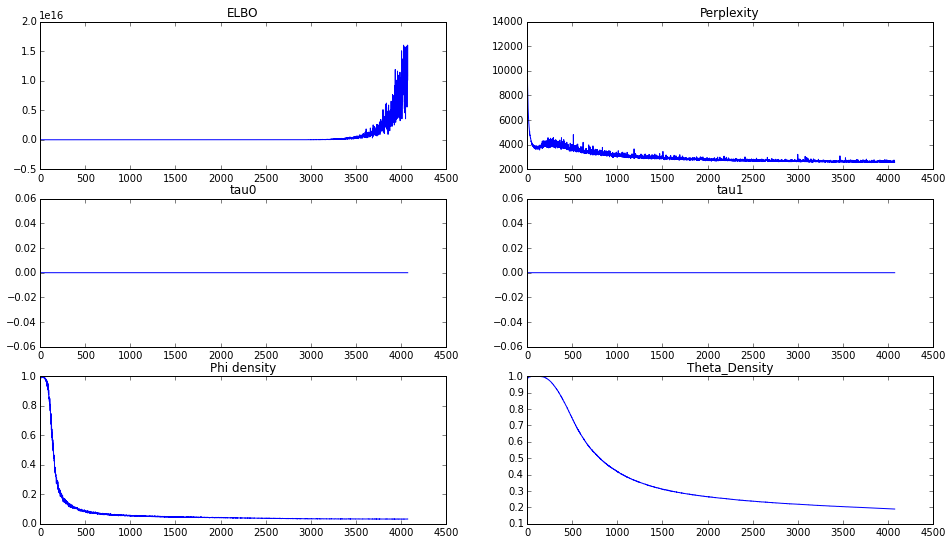

In [172]:
figure(figsize=(16, 9))

things_to_plot = ['elbo', 'perp', 'tau_0', 'tau_1', 'den_phi', 'den_theta']
titles = ['ELBO', 'Perplexity', 'tau0', 'tau1',  'Phi density', 'Theta_Density']

for i in xrange(6):
    subplot(3, 2, i + 1)
    plot(result[things_to_plot[i]])
    #xlim([2500, 3000])
    title(titles[i])

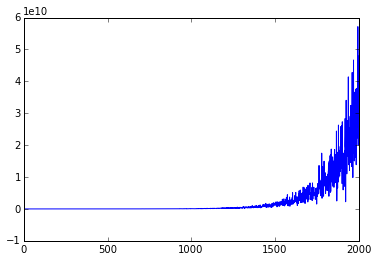

In [135]:
plot(result['elbo'][0:2000])

In [93]:
print 'For 10 topics perp=%0.2f' % np.mean(result['perp'][-100:-1])

For 10 topics perp=2714.72


In [174]:
print 'For 50 topics perp=%0.2f' % np.mean(result['perp'][-100:-1])

For 50 topics perp=2631.20


In [176]:
cur_phi, cur_theta = get_phi_theta()

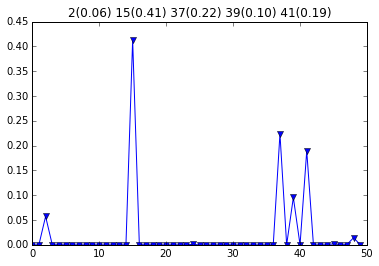

In [201]:
cur_dist = cur_theta[:, -2]
plot(cur_dist, '-v')
top_topics = []
for i in xrange(len(cur_dist)):
    if cur_dist[i] > 0.05:
        top_topics.append((i, cur_dist[i]))
title(' '.join(['%d(%0.2f)' % x for x in top_topics]))

In [94]:
TOPICS_N

50

(-4e-05, -3e-05)

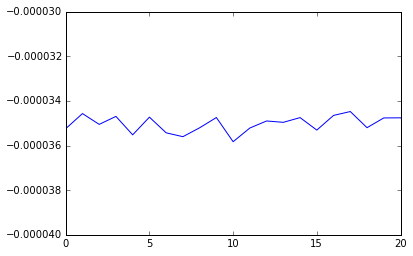

In [76]:
plot(np.array(result['tau_1'][1:]) - np.array(result['tau_1'][0:-1]))
xlim([0, 20])
ylim([-0.00004, -0.000030])

In [ ]:
pd.DataFrame.from_dict(result)

## Debug

In [ ]:
val_mu_phi = mu_phi_values[-2]
nnz_idx = np.nonzero(np.isnan(val_mu_phi))
print nnz_idx

In [ ]:
print val_mu_phi[:, 98].shape
print val_mu_phi[:, 98]
cur_mu_col = mu_phi_values[-2][:, 98]
cur_sigma_col = np.exp(sigma_phi_values[-2][:, 98])
cur_eps_col = np.random.normal(0, 1, size=cur_mu_col.shape)
cur_phi_col = np.exp(cur_mu_col + cur_sigma_col * cur_eps_col) / np.sum(np.exp(cur_mu_col + cur_sigma_col * cur_eps_col))
print 1.0 - cur_phi_col

In [ ]:
cur_sigma_col

In [ ]:
hist(cur_phi_col, bins=50, log=True)
''

In [ ]:
mu_phi.get_value()

In [ ]:
get_phi_theta = theano.function(
    inputs=[],
    outputs=[phi, theta]
    )

In [ ]:
cur_phi, cur_theta = get_phi_theta()

In [208]:
phi.eval()

array([[  0.00000000e+000,   0.00000000e+000,   5.69501849e-009, ...,
          6.88630238e-009,   0.00000000e+000,   8.71491263e-197],
       [  0.00000000e+000,   0.00000000e+000,   2.96130954e-006, ...,
          4.32299031e-007,   0.00000000e+000,   3.84940474e-235],
       [  0.00000000e+000,   0.00000000e+000,   5.68209239e-005, ...,
          3.88871620e-008,   0.00000000e+000,   1.35622349e-232],
       ..., 
       [  0.00000000e+000,   0.00000000e+000,   4.81192339e-013, ...,
          2.10328921e-013,   0.00000000e+000,   5.81470780e-241],
       [  0.00000000e+000,   0.00000000e+000,   4.73769911e-013, ...,
          9.05737957e-014,   0.00000000e+000,   1.35569086e-240],
       [  0.00000000e+000,   0.00000000e+000,   7.82817707e-008, ...,
          9.57386893e-008,   0.00000000e+000,   0.00000000e+000]])